<a href="https://colab.research.google.com/github/vishal13230/quantitative_finance/blob/main/Bajaj_Finance_Stock_Price_Prediction_With_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> *The particular problem pertains to forecasting, forecasting can be of sales, stocks, profits, and demand for new products. Forecasting is a technique that uses historical data as inputs to make informed estimates that are predictive in determining the direction of future trends. Businesses utilize forecasting to determine how to allocate their budgets or plan for anticipated expenses for an upcoming period of time.*
[link text](https://www.analyticsvidhya.com/blog/2020/10/bajaj-finance-stock-price-prediction-time-series/)

In [ ]:
# Install the libraries
!pip install pmdarima
!pip install pycaret
!pip install sklearn-contrib-py-earth

In [ ]:
# Import the libraries
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use("ggplot")
import warnings
warnings.filterwarnings("ignore") 

from pyearth import Earth

from pmdarima import auto_arima 
from pmdarima.arima import ADFTest

from pandas_datareader import data as web
from pandas.plotting import autocorrelation_plot  as ap

import statsmodels.api as sm
import statsmodels.stats.diagnostic as dg
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.stattools import durbin_watson 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tsa.holtwinters import Holt, SimpleExpSmoothing, ExponentialSmoothing, HoltWintersResults

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV

In [ ]:
# Get the stock/portfolio starting date
start_date = datetime.datetime(2015, 1, 1)

# Get the stock/portfolio ending date
end_date = datetime.datetime(2019, 12, 31)

In [ ]:
# Load the data

stock_df = web.DataReader("BAJFINANCE.NS", data_source = "yahoo", start = start_date, end = end_date)

In [ ]:
# Head and tail of data
stock_df.head()
stock_df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-26,4196.450195,4133.250000,4149.950195,4187.100098,1265020.0,4177.498535
2019-12-27,4260.000000,4192.000000,4198.000000,4252.649902,1126648.0,4242.897949
2019-12-30,4281.549805,4230.000000,4274.850098,4243.299805,831910.0,4233.569336
2019-12-31,4266.399902,4218.600098,4247.000000,4234.750000,779608.0,4225.039062
2020-01-01,4252.000000,4221.000000,4237.799805,4231.299805,407042.0,4221.596680


In [ ]:
# Get the info of the data
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1229 entries, 2015-01-01 to 2020-01-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1229 non-null   float64
 1   Low        1229 non-null   float64
 2   Open       1229 non-null   float64
 3   Close      1229 non-null   float64
 4   Volume     1229 non-null   float64
 5   Adj Close  1229 non-null   float64
dtypes: float64(6)
memory usage: 67.2 KB


In [ ]:
# Create a copy of the data
stock_df_copy = stock_df.copy()

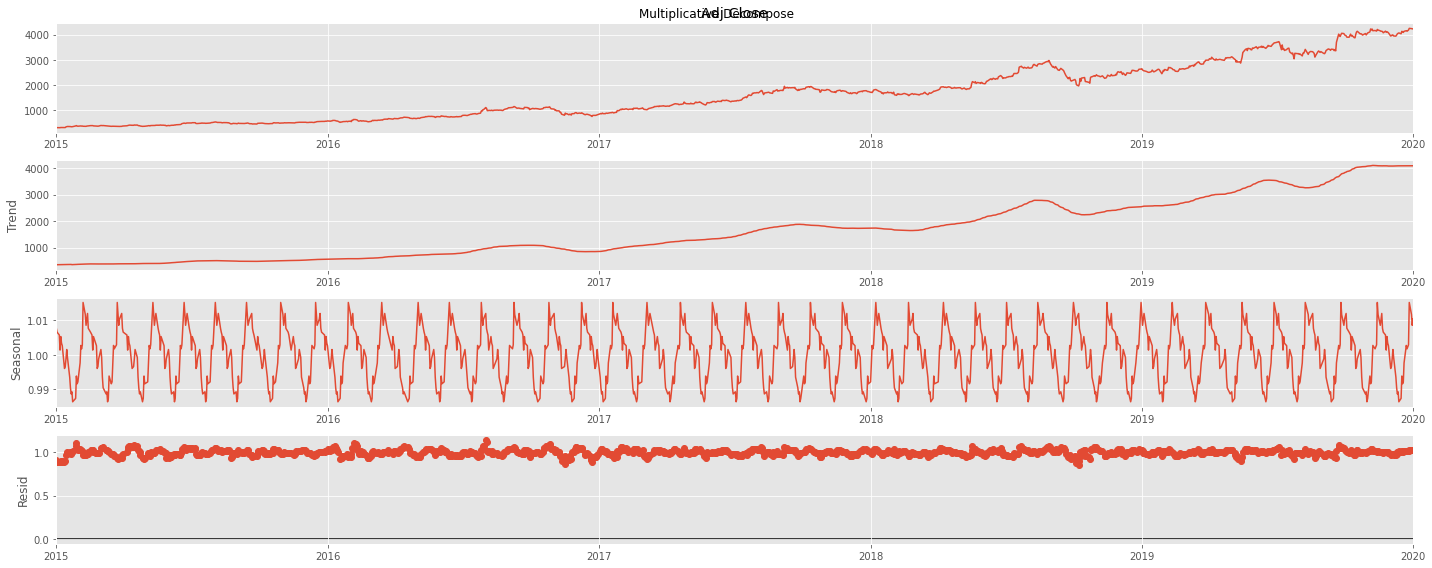

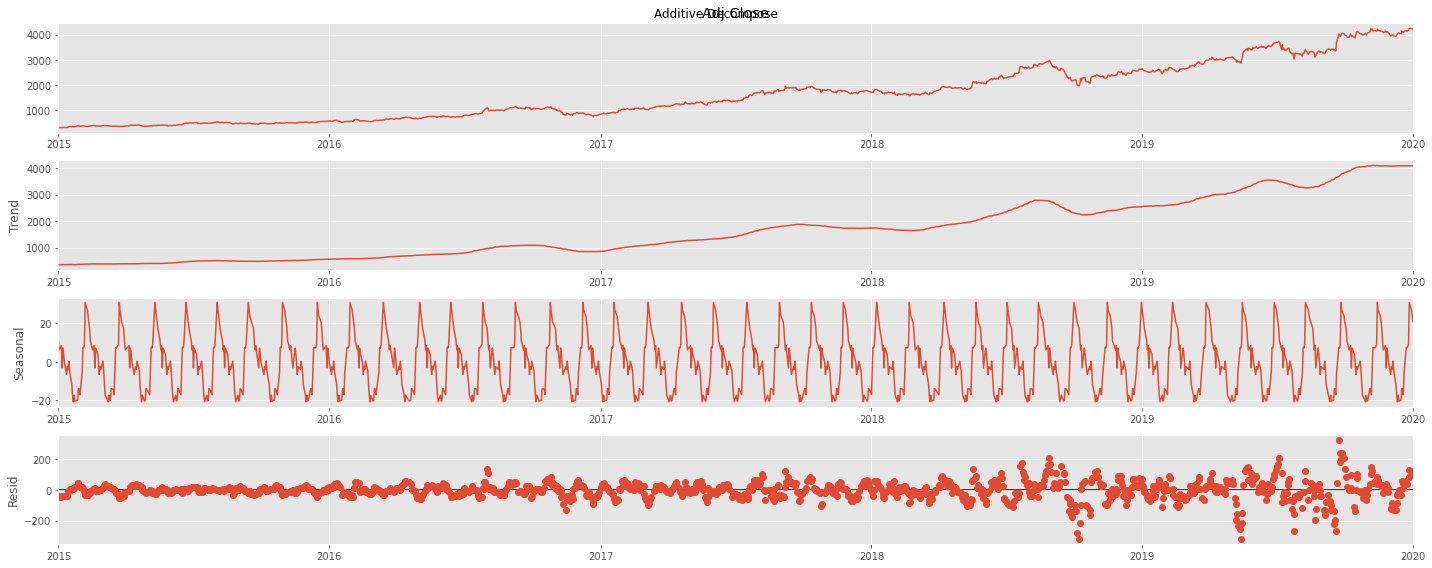

In [ ]:
# Let's perform seasonal decompose, to break it up into Observed, trend, seasonality, and residual components

# Multiplicative Decomposition 
result_mul = seasonal_decompose(stock_df["Adj Close"], model = "multiplicative", period = 30, extrapolate_trend = "freq")

# Additive Decomposition
result_add = seasonal_decompose(stock_df["Adj Close"], model = "additive", period = 30, extrapolate_trend = "freq")

# Plot the decomposition
plt.rcParams.update({"figure.figsize": (20, 8)})
result_mul.plot().suptitle("Multiplicative Decompose")
result_add.plot().suptitle("Additive Decompose")
plt.show()

>  One of the important features of the ARIMA model is that the time series used for modeling should be stationary. By stationarity I mean, the statistical property of time series should remain constant over time, meaning it should have a constant mean and variance. he trend and seasonality will affect the value of the time series at different times.

> One simple technique is to plot and check. We have statistical tests like ADF tests(Augmented Dickey-Fuller Tests).ADF tests the null hypothesis that a unit root is present in the sample. The alternative hypothesis is different depending on which version of the test is used but is usually stationarity or trend-stationarity. It is an augmented version of the Dickey-Fuller test for a larger and more complicated set of time series models. The augmented Dickey-Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.So if value p value<alpha(significance) ,we will reject the null hypothesis,i.e presence of unit root.



In [ ]:
# ADF test to check the stationarity
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(stock_df["Adj Close"])

(0.6439487548474989, True)

In [ ]:
# Calculating P values 
X = stock_df["Adj Close"]
result = adfuller(X)
print("ADF Statistic: %f" % result[0])
print("P-value: %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
	print("\t%s: %.3f" % (key, value))

ADF Statistic: 0.950823
P-value: 0.993719
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [ ]:
# P values indicate ts is not stationarity ,time series is required to me made stationary
# Differencing: The order of differencing (q) refers to the no of times you difference the time series to make it stationary. 
# By difference, I mean you subtract the current value from the previous value. After Differencing you again perform the 
# ADF test to check whether the time series has become stationary or you can plot and check. Log Transformation: 
# We can make the time series stationary by doing a log transformation of the variables. We can use this if the time series is diverging.

In [ ]:
# First order differencing
X = X.diff(1)

In [ ]:
# Print the new x values
X.dropna(inplace = True)
print(X)

Date
2015-01-02    -5.165955
2015-01-05    -0.830963
2015-01-06    -0.821747
2015-01-07     6.440094
2015-01-08    -0.549377
                ...    
2019-12-26    47.491211
2019-12-27    65.399414
2019-12-30    -9.328613
2019-12-31    -8.530273
2020-01-01    -3.442383
Name: Adj Close, Length: 1228, dtype: float64
